###     Analysis of the types of customers who purchase chips and their purchasing behaviour within the region

In [2]:
# improt package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from matplotlib import ticker

In [3]:
# import data
behavior = pd.read_csv('data/QVI_purchase_behaviour.csv')
deal = pd.read_csv('data/QVI_transaction_data.csv')
deal.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836.000000,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,43464.036260,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
std,105.389282,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226
min,43282.000000,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,43373.000000,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,43464.000000,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,43555.000000,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,43646.000000,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [4]:
# data overview
behavior_null_cnt =  behavior.isnull().sum()
deal_null_cnt = deal.isnull().sum()
print("Number of null values in Behavior: ","\n", behavior_null_cnt)
print("-"*30)
print("Number of null values in Deal: ","\n", deal_null_cnt)

Number of null values in Behavior:  
 LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64
------------------------------
Number of null values in Deal:  
 DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


In [5]:
behavior.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [6]:
deal

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [7]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [8]:
deal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [9]:
# data preprogressing
# 1. convert 'date' in "deal" to 'date time' format in 'deal_date'
deal['deal_date'] = pd.to_datetime(deal['DATE'], origin='1899-12-30', unit='D')
deal = deal.sort_values(by='deal_date', ascending=True)

# 2. make sure we are looking at the right product--"chip"
    # 2.1 set up excluded keyword

exclude_keywords = [
    'salsa', 'dip',  'cheezels', 'mango chutny'
]
    # 2.2 Screen the products that meet the requirements according to the dictionary
def is_potato_chip(name):
    if pd.isna(name):
        return False
    name_lower = name.lower()

    # excluded not chips
    for word in exclude_keywords:
        if word in name_lower:
            return False
    return True

deal['is_chip'] = deal['PROD_NAME'].apply(is_potato_chip)
chip_deal = deal[deal['is_chip'] == True]

# 3.Eliminate outliers for 'PROD_NBR'--The transaction volume of chips per transaction
'''
    For a normal customer, typically,the number of chips he or she buy should not be larger than 10.
    If it is, it is highly skeptical, we should do further research on that customer.
'''
chip_deal_outliers = chip_deal[chip_deal['PROD_QTY']>10]
outliers_customers = chip_deal_outliers['LYLTY_CARD_NBR'].unique().tolist()
print(outliers_customers)

'''
    In these outliers, there is only one costomer with LYLTY_CARD_NBR-226000
    Check this customer's historical purchase records
'''
chip_deal[chip_deal['LYLTY_CARD_NBR'].isin(outliers_customers)]

'''
    This consumer has purchased potato chips twice, but each time they bought 200 portions, which is clearly incorrect. Perhaps he or she is a retailer, therefore, they should be excluded
'''
chip_deal = chip_deal[~chip_deal['LYLTY_CARD_NBR'].isin(outliers_customers)]

# 4.check if there are other data issues
print('Number of date:' , chip_deal['deal_date'].nunique())
    # 4.1 In 2019, there is 365days. But here, there is only 364 datas which indicates a missing date. In that date, there was no chip been sold.
full_date_range = pd.date_range(start=chip_deal['deal_date'].min(),end = chip_deal['deal_date'].max(), freq = 'D')
full_date = pd.DataFrame(full_date_range, columns = ['deal_date'])
    # 4.2 aggregate datas and creat daily sales, let the missing date has no sale
daily_sales = chip_deal.groupby('deal_date').agg(
    total_qty=("PROD_QTY","sum"),
    total_sales = ("TOT_SALES","sum")
).reset_index()
    # 4.3 left join full_Date + daily_sale, fill the days with no sales as 0
actual_daily_sales = full_date.merge(daily_sales,on='deal_date',how='left')
actual_daily_sales['total_qty'] = actual_daily_sales['total_qty'].fillna(0)
actual_daily_sales['total_sales'] = actual_daily_sales['total_sales'].fillna(0)

[226000]
Number of date: 364


## Visualization and Analysis

**Transactions over Time: number of transactions each day--Quantity and Revenue**

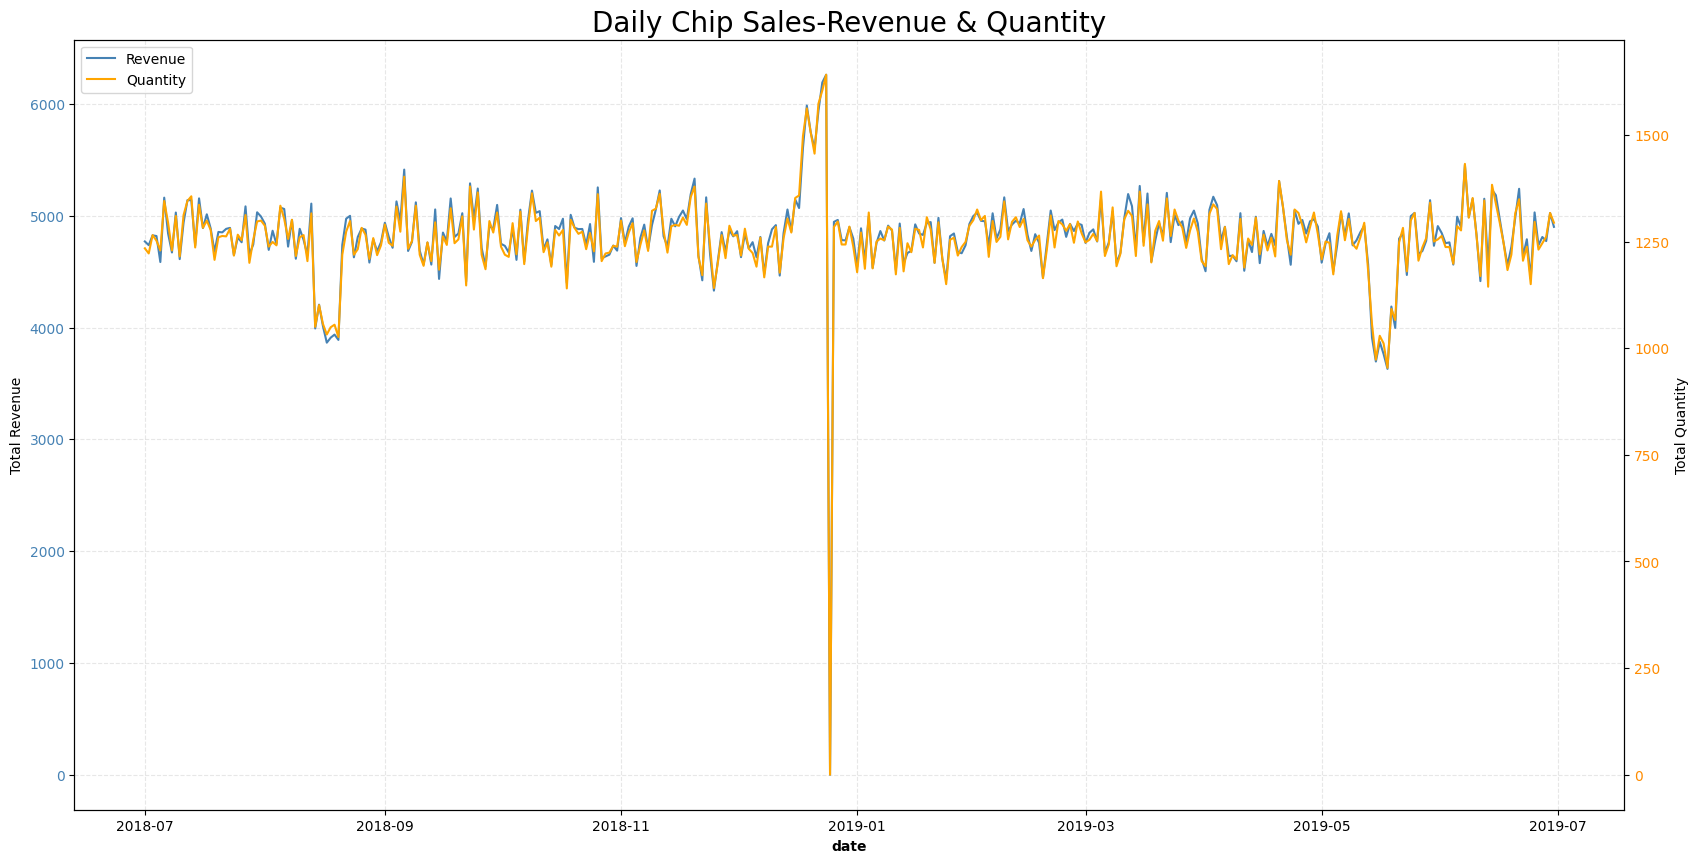

In [10]:
figure,ax1 = plt.subplots(figsize=(20,10))

line1 = ax1.plot(actual_daily_sales['deal_date'],actual_daily_sales['total_sales'],color='steelblue',label='Revenue')
ax1.set_xlabel("date",fontweight='bold')
ax1.set_ylabel('Total Revenue')
ax1.grid(True,linestyle='--',alpha=0.3)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
line2 = ax2.plot(actual_daily_sales['deal_date'],actual_daily_sales['total_qty'],color='orange',label='Quantity')
ax2.set_ylabel("Total Quantity")
ax2.tick_params(axis='y', labelcolor='darkorange')
lines = line1 + line2
labels = [i.get_label() for i in lines]
plt.legend( lines,labels, loc='upper left',fontsize=10)
plt.title('Daily Chip Sales-Revenue & Quantity',fontsize=20)
plt.show()

**In December 2018, both sales volume and sales revenue exhibited abnormal fluctuations.**

**Specifically, they steadily increased at the beginning of the month but suddenly plummeted towards the end.**

**Next, let's focus on this period for a detailed analysis**

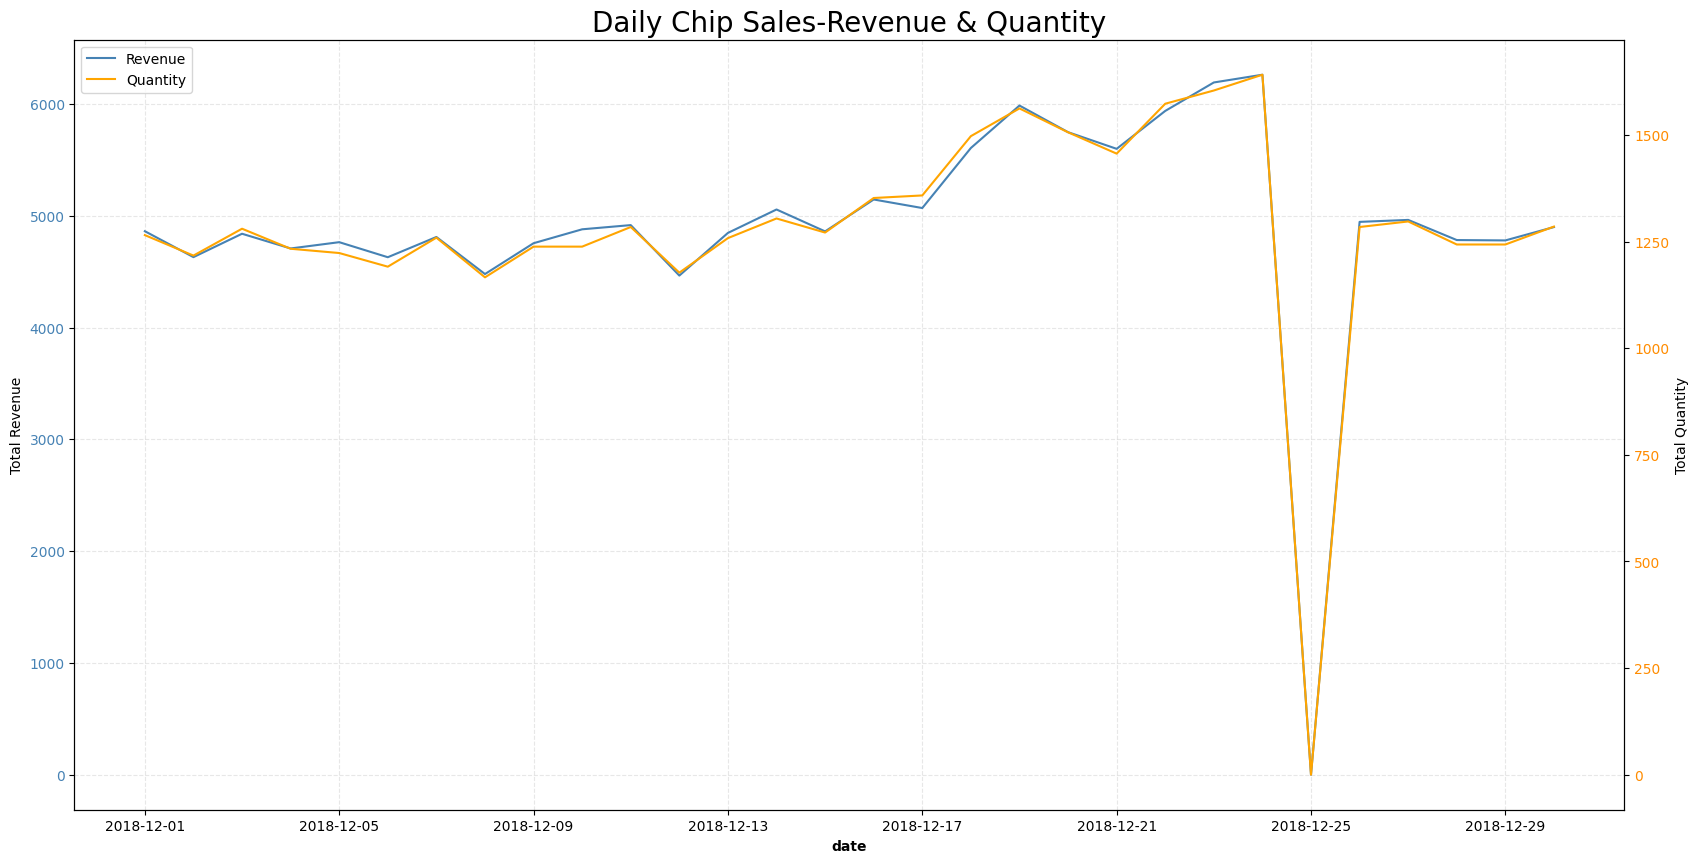

In [11]:
# select data in 2018-12
daily_sales_in_DEC = actual_daily_sales[(actual_daily_sales['deal_date']>= '2018-12-01') & (daily_sales['deal_date']< '2019-01-01') ]
#visualization and analysis
figure,ax1 = plt.subplots(figsize=(20,10))
#Transactions over Time: number of transactions each day--Quantity and Revenue in 2018-12
line1 = ax1.plot(daily_sales_in_DEC['deal_date'],daily_sales_in_DEC['total_sales'],color='steelblue',label='Revenue')
ax1.set_xlabel("date",fontweight='bold')
ax1.set_ylabel('Total Revenue')
ax1.grid(True,linestyle='--',alpha=0.3)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
line2 = ax2.plot(daily_sales_in_DEC['deal_date'],daily_sales_in_DEC['total_qty'],color='orange',label='Quantity')
ax2.set_ylabel("Total Quantity")
ax2.tick_params(axis='y', labelcolor='darkorange')
lines = line1 + line2
labels = [i.get_label() for i in lines]
plt.legend( lines,labels, loc='upper left',fontsize=10)
plt.title('Daily Chip Sales-Revenue & Quantity',fontsize=20)
plt.show()

**The increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself.**

**This is due to shops being closed on Christmas day.**

## Category analysis

**Examine the impact of different brands and package sizes on sales volume and sales revenue**

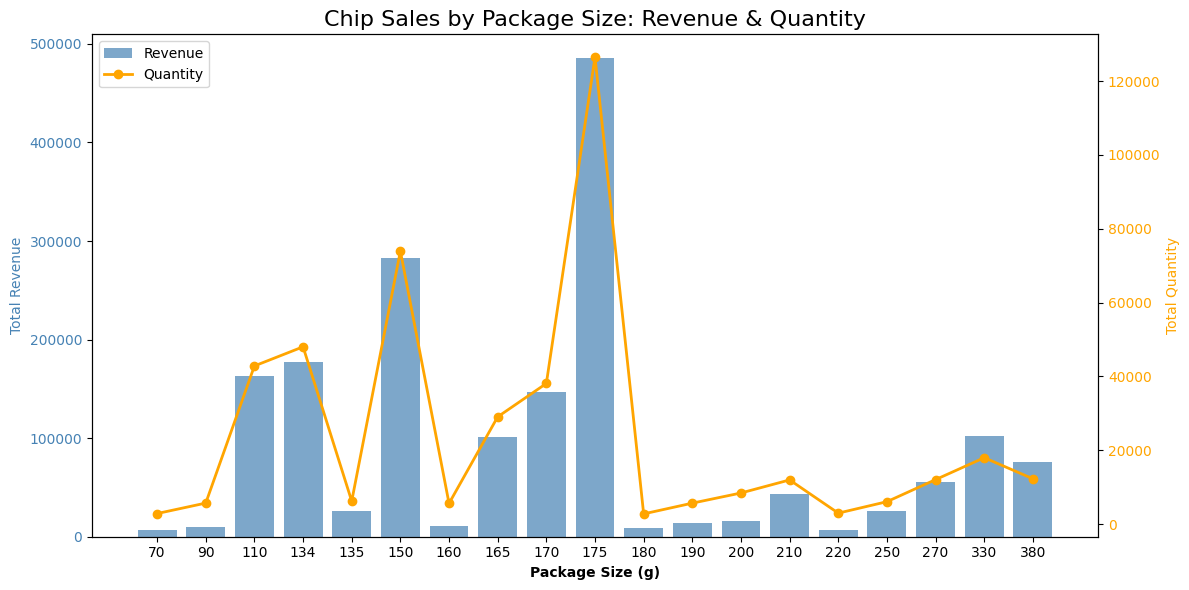

In [12]:
# For package sizes
#   1. extra  keywords in PROD_NAME that represent the pack size
chip_deal['pack_size'] = (chip_deal['PROD_NAME'].str.extract(r'(\d+)\s*g',flags=re.IGNORECASE)).astype("int64")

#   2.group the datas by sizes
chip_deal_size = chip_deal.groupby('pack_size').agg(
    total_qty = ("PROD_QTY","sum"),
    total_sales = ("TOT_SALES","sum")
).reset_index()
chip_deal_size.sort_values('pack_size',ascending=True,inplace=True)
chip_deal_size.reset_index(drop=True, inplace=True)
chip_deal_size['pack_size'] = chip_deal_size['pack_size'].astype('str')

#   3.visualization
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(chip_deal_size['pack_size'], chip_deal_size['total_sales'],
        color='steelblue', alpha=0.7, label='Revenue')
ax1.set_xlabel('Package Size (g)', fontweight='bold')
ax1.set_ylabel('Total Revenue', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(chip_deal_size['pack_size'], chip_deal_size['total_qty'],
         color='orange', marker='o', linewidth=2, label='Quantity')
ax2.set_ylabel('Total Quantity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title('Chip Sales by Package Size: Revenue & Quantity', fontsize=16)
plt.tight_layout()
plt.show()

**The packaging size of potato chips ranges from a maximum of 380g to a minimum of 70g, which is reasonable.**

**Looking at the bar chart and line chart, the sales volume of 175g is the highest, followed by 150g**

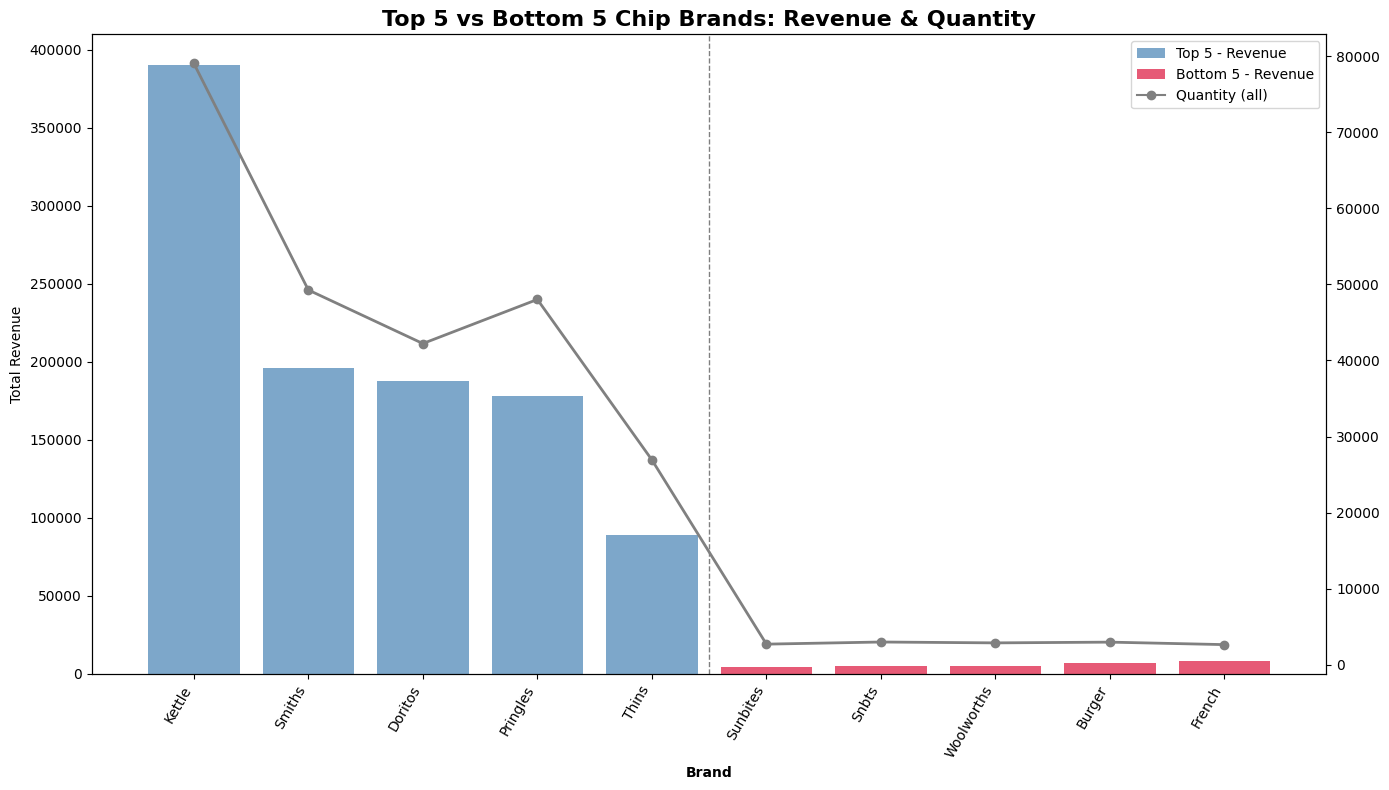

In [13]:
# For brands
#   1. extra  the first word in PROD_NAME as the brand name
chip_deal['brand'] = (chip_deal['PROD_NAME'].str.extract(r'^(\w+)',flags=re.IGNORECASE)[0]).astype("str")

#   2.group the datas by sizes
chip_deal_brand = chip_deal.groupby('brand').agg(
    total_qty = ("PROD_QTY","sum"),
    total_sales = ("TOT_SALES","sum")
).reset_index()

#Select the top 5 brands and the bottom 5 brands by sales volume
top5=chip_deal_brand.sort_values('total_sales',ascending=False).head(5)
bottom5 = chip_deal_brand.sort_values('total_sales',ascending=True).head(5)

top5['group'] = 'Top 5'
bottom5['group'] = 'Bottom 5'
combined = pd.concat([top5, bottom5], ignore_index=True)

#   3.visualization-top 5 and bottom5
fig, ax1 = plt.subplots(figsize=(14, 8))

x = range(len(combined))
labels = combined['brand'].tolist()

# Revenue histogram
colors_revenue = ['steelblue' if g == 'Top 5' else 'crimson' for g in combined['group']]
bars = ax1.bar(x, combined['total_sales'], color=colors_revenue, alpha=0.7, label='Revenue')

ax1.set_xlabel('Brand', fontweight='bold')
ax1.set_ylabel('Total Revenue', color='black')
ax1.tick_params(axis='y')

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=60, ha='right')

# Quantity plot
ax2 = ax1.twinx()
colors_qty = ['orange' if g == 'Top 5' else 'cornflowerblue' for g in combined['group']]
line = ax2.plot(x, combined['total_qty'], color='gray', marker='o', linewidth=2, markersize=6, label='Quantity')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Top 5 - Revenue'),
    Patch(facecolor='crimson', alpha=0.7, label='Bottom 5 - Revenue'),
    Line2D([0], [0], color='gray', marker='o', linestyle='-', label='Quantity (all)')
]
ax1.legend(handles=legend_elements, loc='upper right')
ax1.axvline(x=4.5, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.title('Top 5 vs Bottom 5 Chip Brands: Revenue & Quantity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [23]:
print('-------Brand Analysis-------')

highest_sales_brand = top5['brand'].iloc[0]
highest_sales = top5['total_sales'].iloc[0]
highest_quantity = top5['total_qty'].iloc[0]
highest_sales_proportion = round(100*highest_sales/(chip_deal_brand['total_sales'].sum()), 2)
highest_quantity_proportion = round(100*highest_quantity/(chip_deal_brand['total_qty'].sum()), 2)

lowest_sales_brand = bottom5['brand'].iloc[0]
lowest_sales = bottom5['total_sales'].iloc[0]
lowest_quantity = bottom5['total_qty'].iloc[0]
lowest_sales_proportion = round(100*lowest_sales/(chip_deal_brand['total_sales'].sum()), 2)
lowest_quantity_proportion = round(100*lowest_quantity/(chip_deal_brand['total_qty'].sum()), 2)

lowest_in_top5 = top5['total_sales'].iloc[4]
total_sales_in_bottom5 = bottom5['total_sales'].sum()

print(f'\nThe brand with the highest sales volume is {highest_sales_brand}, with sales volume of {highest_quantity} and sales revenue of {highest_sales},the proportion of sales volume is {highest_sales_proportion}%,the proportion of sales quantity is {highest_quantity_proportion}%')

print(f'\nThe brand with the lowest sales volume is {lowest_sales_brand}, with sales volume of {lowest_sales} and sales revenue of {lowest_quantity},the proportion of sales volume is {lowest_sales_proportion}%,the proportion of sales quantity is {lowest_quantity_proportion}%')

print(f'\nAmong the top five brands in terms of sales volume, the sales volume of the brand with the smallest sales volume is {round(lowest_in_top5/total_sales_in_bottom5,2)} times the combined sales volume of the bottom five brands')

-------Brand Analysis-------

The brand with the highest sales volume is Kettle, with sales volume of 79051 and sales revenue of 390239.8,the proportion of sales volume is 22.2%,the proportion of sales quantity is 17.22%

The brand with the lowest sales volume is Sunbites, with sales volume of 4600.2 and sales revenue of 2706,the proportion of sales volume is 0.26%,the proportion of sales quantity is 0.59%

Among the top five brands in terms of sales volume, the sales volume of the brand with the smallest sales volume is 3.0 times the combined sales volume of the bottom five brands


## Customer Analysis

In [15]:
# Merge transaction data to customer data and make sure they are merge well.
customer_deal = chip_deal.merge(behavior,on = 'LYLTY_CARD_NBR', how = 'inner')
customer_num = customer_deal['LYLTY_CARD_NBR'].count()
original_num = chip_deal['LYLTY_CARD_NBR'].count()

# check if there are duplicates
if customer_num == original_num:
    print("The number of rows in `customer_deal` is the same as that of `chip_deal`, we can be sure that no duplicates were created.")
else:
    print("Some duplicates might be created.")
# check if there are nulls
if customer_deal.isnull().sum().sum():
    print("There are some nulls!")
else:
    print("\nThere are no nulls!So all our customers in the transaction data has been accounted for in the customer dataset.")

The number of rows in `customer_deal` is the same as that of `chip_deal`, we can be sure that no duplicates were created.

There are no nulls!So all our customers in the transaction data has been accounted for in the customer dataset.


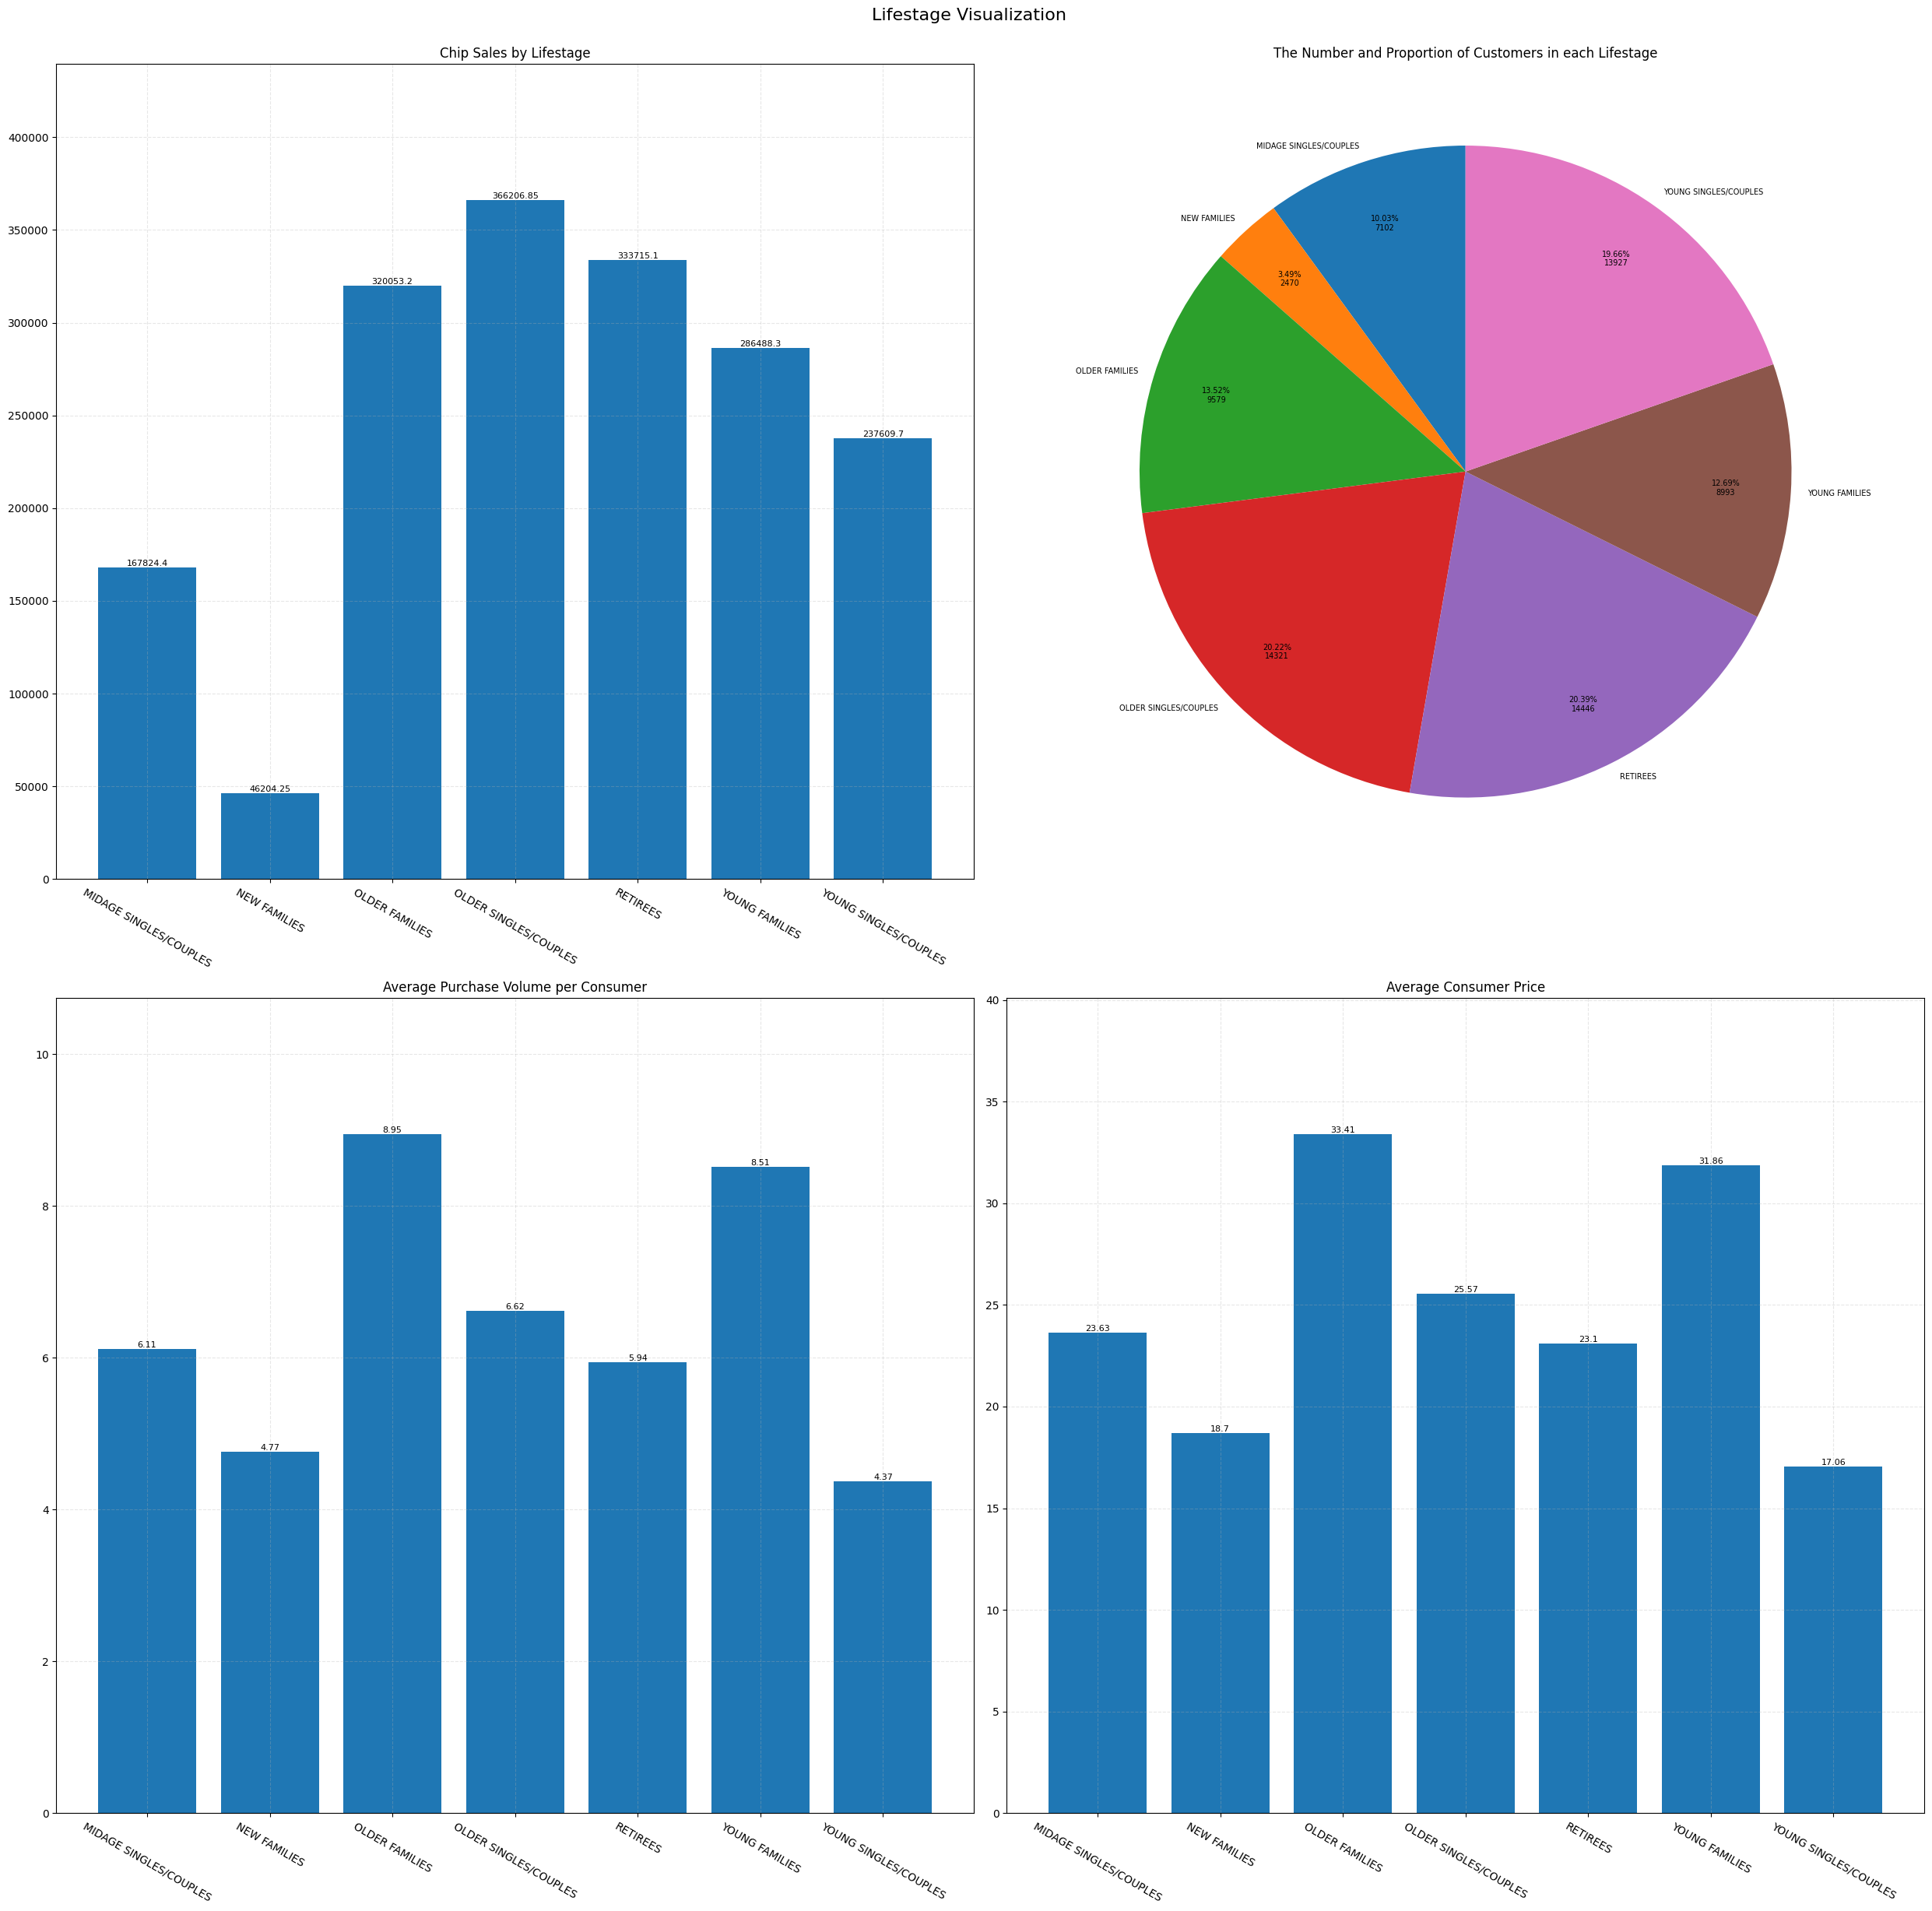

In [26]:
# Who spends the most on chips (total sales)-- by lifestage and Premium level
colors = ['#ff4499','#ff9999','#ffcc99','#99ff99','#66b3ff']
# For customers in different lifestage
customer_deal_lifestage = customer_deal.groupby([ 'LIFESTAGE']).agg(
    total_customers = ('LYLTY_CARD_NBR','nunique'),
    total_sales=('TOT_SALES','sum'),
    total_qty=('PROD_QTY','sum')
).reset_index()


# Visualization

def compute_fraction(pct, allvals):
    absolute = int(pct/100 * np.sum(allvals))
    return '{:.2f}%\n{:d}'.format(pct, absolute)

fig,ax = plt.subplots(2,2,figsize=(25,25))
fig.suptitle('Lifestage Visualization', fontsize=16,ha = 'center')

# Chip Sales by Lifestage
ax1=ax[0,0]
ax1.bar(
    customer_deal_lifestage['LIFESTAGE'],
    customer_deal_lifestage['total_sales'],
)
ax1.set_title('Chip Sales by Lifestage')
ax1.grid(linestyle='--',alpha=0.3)
ax1.set_ylim([0,max(customer_deal_lifestage['total_sales'])*1.2])
for x,y in zip(customer_deal_lifestage['LIFESTAGE'],customer_deal_lifestage['total_sales']):
    ax1.text(x,y,str(y),ha='center',va='bottom',fontsize=8)
ax1.tick_params(axis='x', rotation=-30)

# How many customers are in each segment
ax2 = ax[0,1]

ax2.pie(
    customer_deal_lifestage['total_customers'],
    labels = customer_deal_lifestage['LIFESTAGE'] ,
    autopct=lambda pct: compute_fraction(pct, customer_deal_lifestage['total_customers']),
    startangle=90,
    textprops={'fontsize':7},
    labeldistance=1.05,
    pctdistance=0.8
)
ax2.set_title('The Number and Proportion of Customers in each Lifestage')

# How many chips are bought per customer by segment
ax3 = ax[1,0]
ax3.bar(
    customer_deal_lifestage['LIFESTAGE'],
    customer_deal_lifestage['total_qty']/customer_deal_lifestage['total_customers'],
)
ax3.set_title('Average Purchase Volume per Consumer')
ax3.grid(linestyle='--',alpha=0.3)
ax3.set_ylim([0,max(customer_deal_lifestage['total_qty']/customer_deal_lifestage['total_customers'])*1.2])
for x,y in zip(customer_deal_lifestage['LIFESTAGE'],customer_deal_lifestage['total_qty']/customer_deal_lifestage['total_customers']):
    ax3.text(x,y,str(round(y,2)),ha='center',va='bottom',fontsize=8)
ax3.tick_params(axis='x', rotation=-30)

#Average chip price by customer segment
ax4 = ax[1,1]
ax4.bar(
    customer_deal_lifestage['LIFESTAGE'],
    customer_deal_lifestage['total_sales']/customer_deal_lifestage['total_customers'],
)
ax4.set_title('Average Consumer Price')
ax4.grid(linestyle='--',alpha=0.3)
ax4.set_ylim([0,max(customer_deal_lifestage['total_sales']/customer_deal_lifestage['total_customers'])*1.2])
for x,y in zip(customer_deal_lifestage['LIFESTAGE'],customer_deal_lifestage['total_sales']/customer_deal_lifestage['total_customers']):
    ax4.text(x,y,str(round(y,2)),ha='center',va='bottom',fontsize=8)
ax4.tick_params(axis='x', rotation=-30)

fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('Lifestage_Visualization.png',dpi = 300,bbox_inches='tight')
plt.show()

In [17]:
# Lifestage Analysis


top3_sales = customer_deal_lifestage.sort_values(by='total_sales', ascending=False).head(3)['LIFESTAGE'].tolist()
top3_sales_str = ','.join(str(i) for i in top3_sales)


top3_customer_num = customer_deal_lifestage.sort_values(by='total_customers', ascending=False).head(3)['LIFESTAGE'].tolist()
top3_customer_str = ','.join(str(i) for i in top3_customer_num)


customer_deal_lifestage['average_quant'] = round(
    customer_deal_lifestage['total_qty'] / customer_deal_lifestage['total_customers'].replace(0, pd.NA),
    2
)
top3_average_quant_num = customer_deal_lifestage.sort_values(by='average_quant', ascending=False).head(3)['LIFESTAGE'].tolist()

top3_average_quant_str = ','.join(str(i) for i in top3_average_quant_num)
top3_average_quant_num2 = customer_deal_lifestage.sort_values(by='average_quant', ascending=False).head(3)['average_quant'].tolist()
top3_average_quant_str2 = ','.join(str(i) for i in top3_average_quant_num2)

customer_deal_lifestage['average_price'] = round(
    customer_deal_lifestage['total_sales'] / customer_deal_lifestage['total_customers'].replace(0, pd.NA),
    2
)
top3_average_price_num = customer_deal_lifestage.sort_values(by='average_price', ascending=False).head(3)['LIFESTAGE'].tolist()
top3_average_price_str = ','.join(str(i) for i in top3_average_price_num)
top3_average_price_num2 = customer_deal_lifestage.sort_values(by='average_price', ascending=False).head(3)['average_price'].tolist()
top3_average_price_str2 = ','.join(str(i) for i in top3_average_price_num2)


print(f'''
    ---------------------------------------Lifestage Analysis---------------------------------------
    Based on life stages:
        The three groups with the highest sales are {top3_sales_str};
        The three groups with the highest average quantity are {top3_average_quant_str}, their average quantity is {top3_average_quant_str2};
        The three groups with the highest average price are {top3_average_price_str}, their average price is {top3_average_price_str2};
''')


    ---------------------------------------Lifestage Analysis---------------------------------------
    Based on life stages:
        The three groups with the highest sales are OLDER SINGLES/COUPLES,RETIREES,OLDER FAMILIES;
        The three groups with the highest average quantity are OLDER FAMILIES,YOUNG FAMILIES,OLDER SINGLES/COUPLES, their average quantity is 8.95,8.51,6.62;
        The three groups with the highest average price are OLDER FAMILIES,YOUNG FAMILIES,OLDER SINGLES/COUPLES, their average price is 33.41,31.86,25.57;



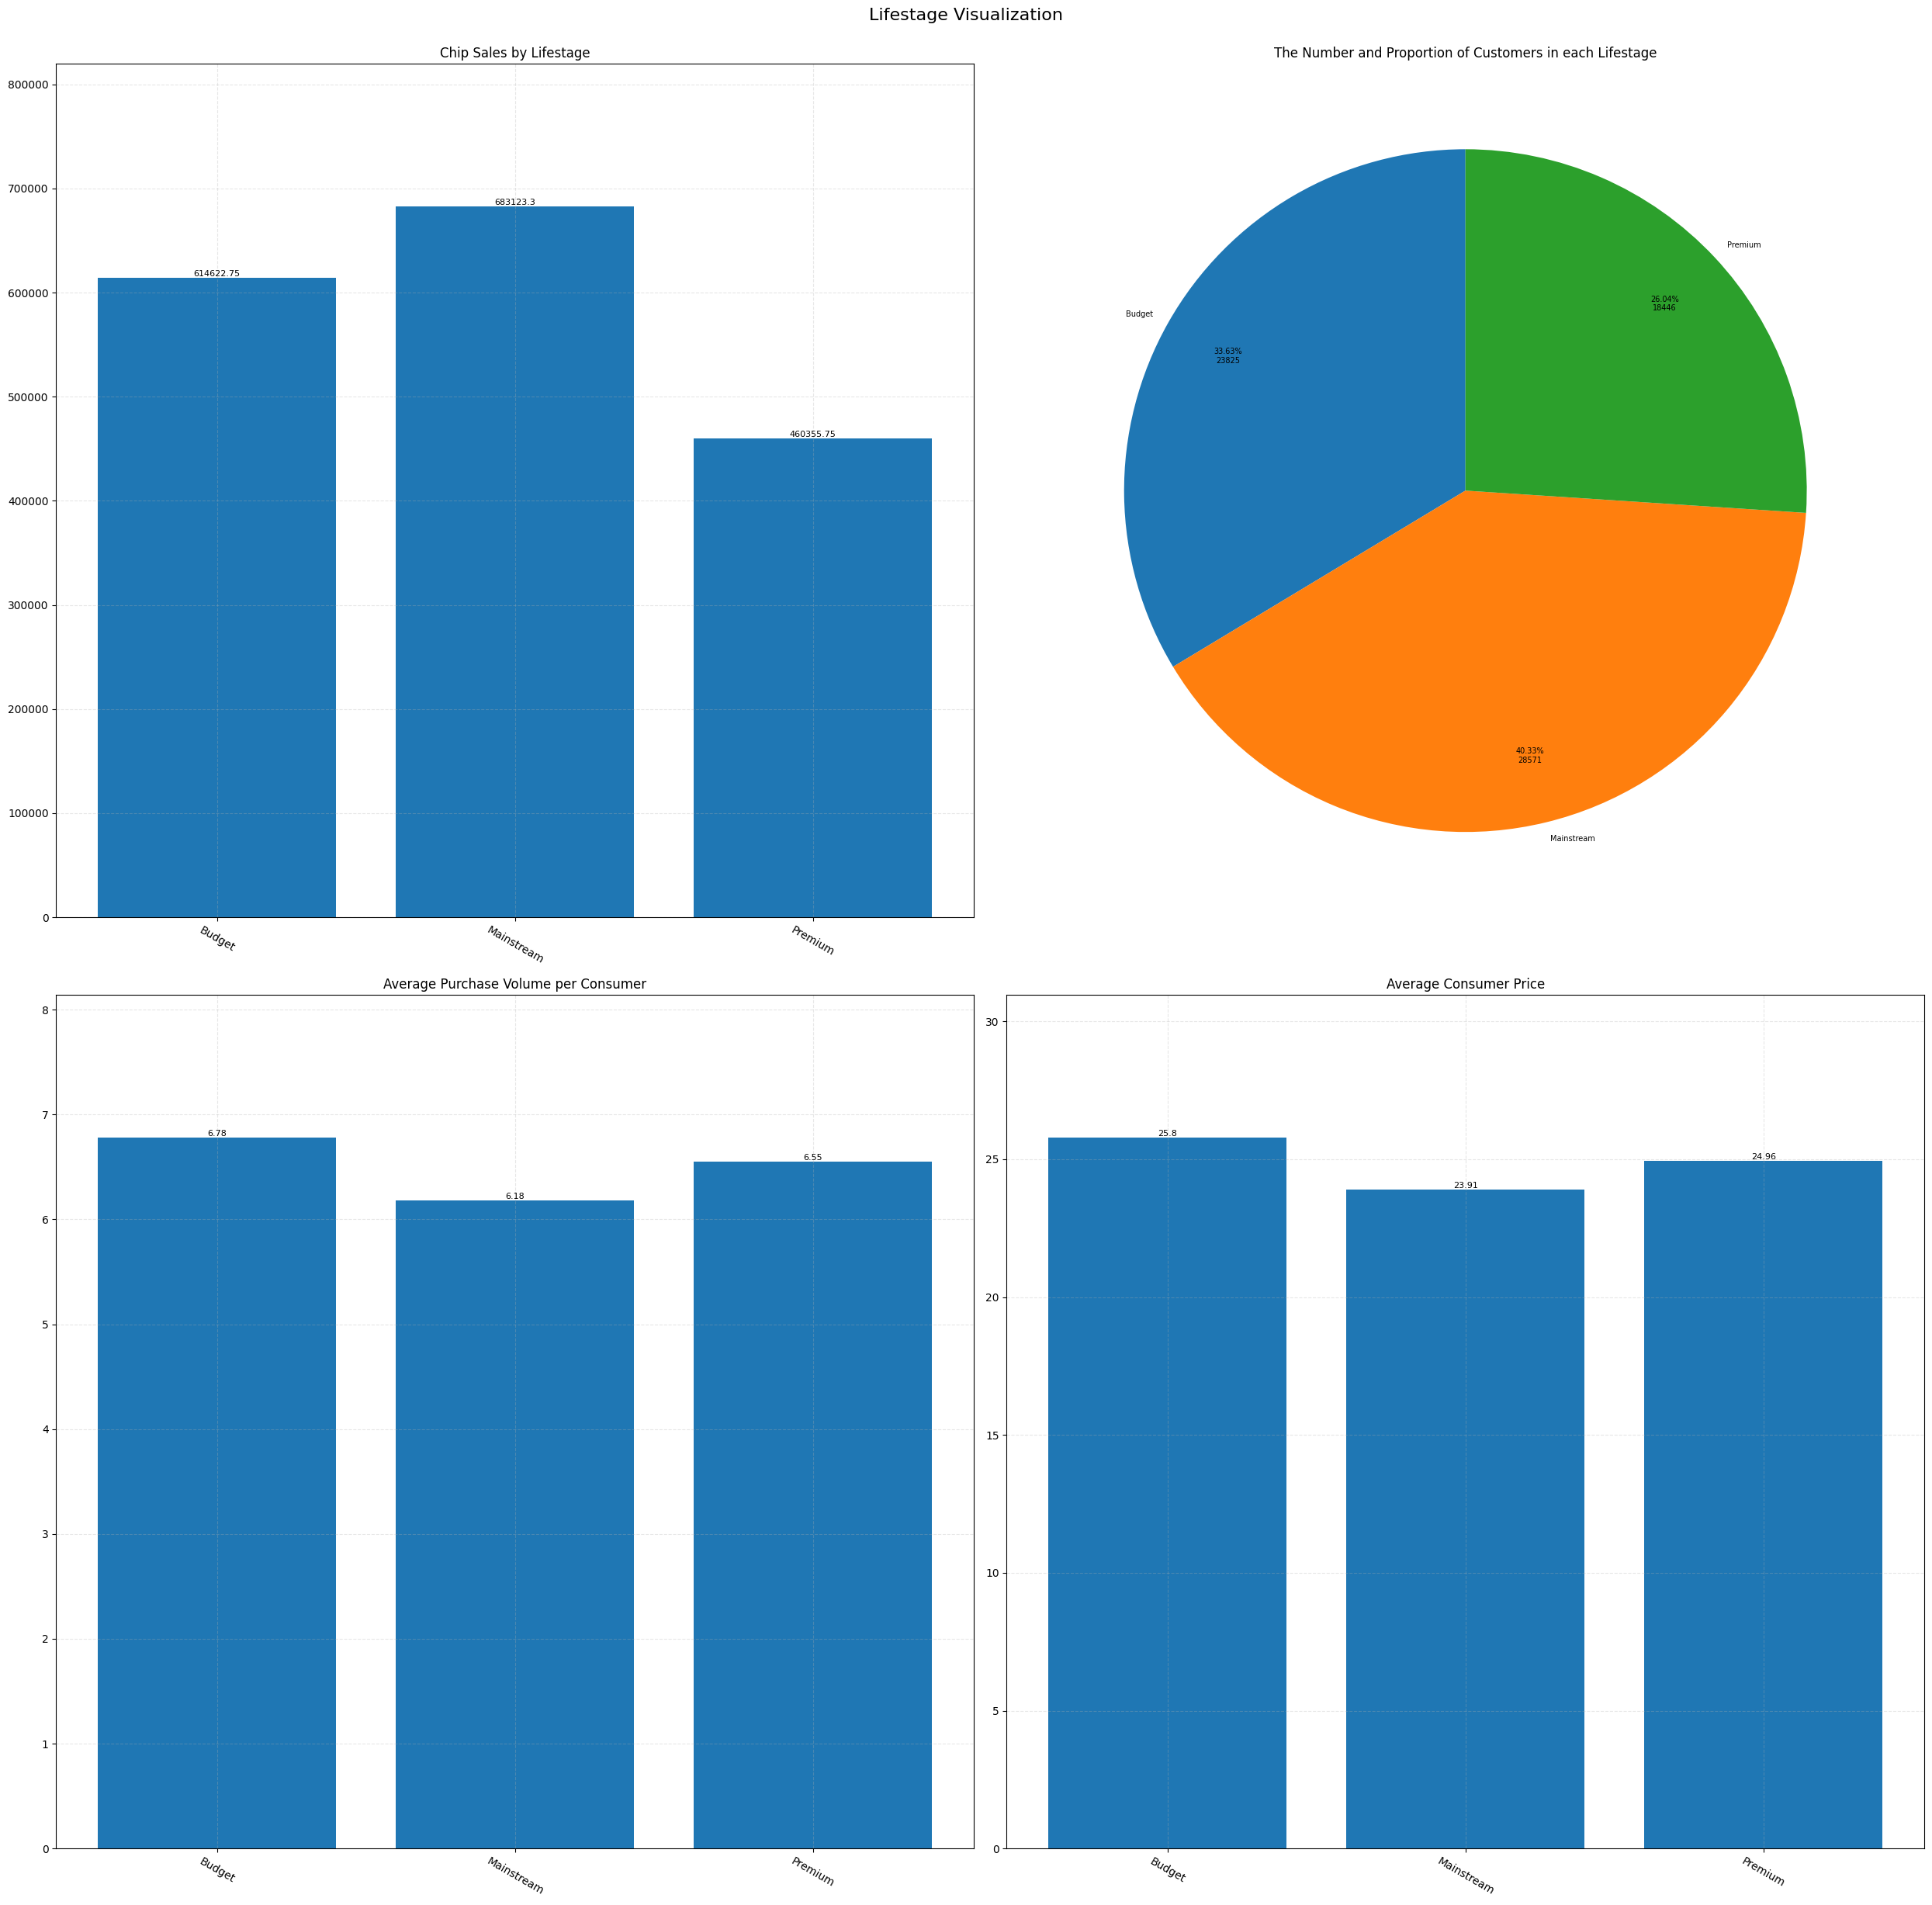

In [27]:
# For customers in different premium levels
customer_deal_premium = customer_deal.groupby([ 'PREMIUM_CUSTOMER']).agg(
    total_customers = ('LYLTY_CARD_NBR','nunique'),
    total_sales=('TOT_SALES','sum'),
    total_qty=('PROD_QTY','sum')
).reset_index()


# Visualization

def compute_fraction(pct, allvals):
    absolute = int(pct/100 * np.sum(allvals))
    return '{:.2f}%\n{:d}'.format(pct, absolute)

fig,ax = plt.subplots(2,2,figsize=(25,25))
fig.suptitle('Lifestage Visualization', fontsize=16,ha = 'center')

# Chip Sales by Lifestage
ax1=ax[0,0]
ax1.bar(
    customer_deal_premium['PREMIUM_CUSTOMER'],
    customer_deal_premium['total_sales']
)
ax1.set_title('Chip Sales by Lifestage')
ax1.grid(linestyle='--',alpha=0.3)
ax1.set_ylim([0,max(customer_deal_premium['total_sales'])*1.2])
for x,y in zip(customer_deal_premium['PREMIUM_CUSTOMER'],customer_deal_premium['total_sales']):
    ax1.text(x,y,str(y),ha='center',va='bottom',fontsize=8)
ax1.tick_params(axis='x', rotation=-30)

# How many customers are in each segment
ax2 = ax[0,1]

ax2.pie(
    customer_deal_premium['total_customers'],
    labels = customer_deal_premium['PREMIUM_CUSTOMER'] ,
    autopct=lambda pct: compute_fraction(pct, customer_deal_premium['total_customers']),
    startangle=90,
    textprops={'fontsize':7},
    labeldistance=1.05,
    pctdistance=0.8,
)
ax2.set_title('The Number and Proportion of Customers in each Lifestage')

# How many chips are bought per customer by segment
ax3 = ax[1,0]
ax3.bar(
    customer_deal_premium['PREMIUM_CUSTOMER'],
    customer_deal_premium['total_qty']/customer_deal_premium['total_customers'],
)
ax3.set_title('Average Purchase Volume per Consumer')
ax3.grid(linestyle='--',alpha=0.3)
ax3.set_ylim([0,max(customer_deal_premium['total_qty']/customer_deal_premium['total_customers'])*1.2])
for x,y in zip(customer_deal_premium['PREMIUM_CUSTOMER'],customer_deal_premium['total_qty']/customer_deal_premium['total_customers']):
    ax3.text(x,y,str(round(y,2)),ha='center',va='bottom',fontsize=8)
ax3.tick_params(axis='x', rotation=-30)

#Average chip price by customer segment
ax4 = ax[1,1]
ax4.bar(
    customer_deal_premium['PREMIUM_CUSTOMER'],
    customer_deal_premium['total_sales']/customer_deal_premium['total_customers'],
)
ax4.set_title('Average Consumer Price')
ax4.grid(linestyle='--',alpha=0.3)
ax4.set_ylim([0,max(customer_deal_premium['total_sales']/customer_deal_premium['total_customers'])*1.2])
for x,y in zip(customer_deal_premium['PREMIUM_CUSTOMER'],customer_deal_premium['total_sales']/customer_deal_premium['total_customers']):
    ax4.text(x,y,str(round(y,2)),ha='center',va='bottom',fontsize=8)
ax4.tick_params(axis='x', rotation=-30)
plt.savefig('Premium_Level_Visualization.png',dpi = 300,bbox_inches='tight')
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [19]:
# Premium Levels Analysis
customer_deal_premium['average_quant'] = round(
    customer_deal_premium['total_qty'] / customer_deal_premium['total_customers'].replace(0, pd.NA),
    2
)

customer_deal_premium['average_price'] = round(
    customer_deal_premium['total_sales'] / customer_deal_premium['total_customers'].replace(0, pd.NA),
    2
)


sorted_by_sales = customer_deal_premium.sort_values(by='total_sales', ascending=False).head(3)
top3_sales_level = sorted_by_sales['PREMIUM_CUSTOMER'].tolist()  # 会员等级
top3_sales_value = sorted_by_sales['total_sales'].tolist()       # 销售额数值
top3_sales_level_str = ','.join(str(i) for i in top3_sales_level)
top3_sales_value_str = ','.join(str(i) for i in top3_sales_value)


sorted_by_customers = customer_deal_premium.sort_values(by='total_customers', ascending=False).head(3)
top3_customer_level = sorted_by_customers['PREMIUM_CUSTOMER'].tolist()
top3_customer_value = sorted_by_customers['total_customers'].tolist()
top3_customer_level_str = ','.join(str(i) for i in top3_customer_level)
top3_customer_value_str = ','.join(str(i) for i in top3_customer_value)


sorted_by_avg_quant = customer_deal_premium.sort_values(by='average_quant', ascending=False).head(3)
top3_avg_quant_level = sorted_by_avg_quant['PREMIUM_CUSTOMER'].tolist()
top3_avg_quant_value = sorted_by_avg_quant['average_quant'].tolist()
top3_avg_quant_level_str = ','.join(str(i) for i in top3_avg_quant_level)
top3_avg_quant_value_str = ','.join(str(i) for i in top3_avg_quant_value)


sorted_by_avg_price = customer_deal_premium.sort_values(by='average_price', ascending=False).head(3)
top3_avg_price_level = sorted_by_avg_price['PREMIUM_CUSTOMER'].tolist()
top3_avg_price_value = sorted_by_avg_price['average_price'].tolist()
top3_avg_price_level_str = ','.join(str(i) for i in top3_avg_price_level)
top3_avg_price_value_str = ','.join(str(i) for i in top3_avg_price_value)


print(f'''
    ---------------------------------------Premium Levels Analysis---------------------------------------
    Based on premium customer levels:
        The three levels with the highest sales are {top3_sales_level_str}, their sales are {top3_sales_value_str};
        The three levels with the highest average quantity are {top3_avg_quant_level_str}, their average quantity is {top3_avg_quant_value_str};
        The three levels with the highest average price are {top3_avg_price_level_str}, their average price is {top3_avg_price_value_str};
''')


    ---------------------------------------Premium Levels Analysis---------------------------------------
    Based on premium customer levels:
        The three levels with the highest sales are Mainstream,Budget,Premium, their sales are 683123.3,614622.75,460355.75;
        The three levels with the highest average quantity are Budget,Premium,Mainstream, their average quantity is 6.78,6.55,6.18;
        The three levels with the highest average price are Budget,Premium,Mainstream, their average price is 25.8,24.96,23.91;

